In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')

# Métodos frecuentistas

Al analizar datos, se puede pensar en dos grandes alternativas:

* Pruebas de hipótesis
* Estimación del tamaño de un efecto junto con la determinación de la incertidumbre

Ambas aproximaciones pueden encararse desde una posición frecuentista o Bayesiana. En este capítulo veremos la forma frecuentista.

Dentro del paradigma frecuentista la primera de estas estrategias es la que tradicionalmente se ha enseñado y divulgado con más énfasis. Mientras que la segunda viene ganando adeptos y se la ha llamado "[nueva estadística](https://www.amazon.com/Understanding-New-Statistics-Meta-Analysis-Multivariate/dp/041587968X)" (aunque las ideas disten bastante de ser realmente nuevas).

Empecemos viendo las pruebas de hipótesis.

## Prueba de hipotesis

La prueba de hipótesis,también llamada test de hipótesis o prueba de significación, es un procedimiento para establecer si una propiedad dada de una población es compatible con lo observado en una muestra de dicha población. 

En la práctica, como la población es desconocida, lo que se hace es pensar una _hipótesis_ la cual nos permite generar una distribución de muestreo, es decir una distribución desde donde se toman (segun cierto procedimiento) _muestras imaginarias_ repetidas veces (idealmente infinitas veces). Luego se compara lo observado con las _muestras imaginarias_ y en función de cuan parecidas sean se establece  el grado de _significancia estadística_. 

Lo dicho en el párrafo anterior se puede tomar literalmente y hacer pruevbas de hipótesis mediante simulaciones. O se puede tomar de forma más conceptual y resolverlo analíticamente. Si alguna vez calcularon algo en estadística que luego buscaban en una tabla llena de números, entonces ustedes hicieron la versión analítica. Acá veremos ambas formas.

De forma general, resumida y algo más formal, tenemos:

1. Calculamos un _estadístico_ $T(\mathcal{D})$ es decir una medida cuantitativa que describe nuestros datos $\mathcal{D}$

2. Generaremos una hipótesis nula $H_{0}$, es decir la hipótesis del no-efecto (la no-diferencia) y asumiendo $H_{0}$ calculamos $T(\mathcal{\tilde D})$

3. Calculamos $valor p \triangleq p(T(\mathcal{\tilde D}) \ge T(\mathcal{D}) ) | H_{0}, I)$. Es decir la probabilidad de obtener un estadístico al menos tan extremo como el observado, asumiendo  $H_{0}$ como cierto y según un procedimiento $I$.

4. Evaluamos si el _valor p_ es _pequeño o grande_. Para esto usamos un valor predefinido, el cual suele ser $\alpha = 0.05$. Si $p < \alpha$ entonces se dice que "rechazamos $H_0$" si en cambio $p \ge \alpha$ se dice que "fallamos en rechazar $H_0$".

### El problema de la moneda según la hipótesis nula

Para hacer esto  más concreto veamos un ejemplo sencillo, que nos acompañará por un buen rato. Supongamos que arrojamos al aire 20 veces una misma moneda y observamos 7 caras y 13 cecas.

¿Es compatible la idea de una moneda que cae la mitad de las veces cara y la mitad ceca con estos datos?

En el ejemplo de la moneda un estadístico podría ser la cantidad de caras $z$ para $n$ tiradas. La hipótesis nula sería que tenemos el mismo número de caras que de cecas, $H_{0} = 0.5$. 

Un par de cosas a notar son que:

* Bajo el paradigma frecuentista no es posible aceptar una hipótesis nula. Por eso los frecuentistas dicen "fallamos en rechazar $H_0$". 
* El computo del *valor p* asume que $H_{0}$ es cierta. Por lo tanto el *valor p* NO es la probabilidad que $H_{0}$ sea cierta, tampoco es la probabilidad de $no H_0$ (la alternativa) sea cierta, ni siquiera es $p(\mathcal{D} | H_0)$.
* Bajo el paradigma frecuentista no es posible preguntarse sobre la probabilidad de un parámetro tome tal o cual valor. Los parámetros tienen valores fijos (aunque desconocidos). Por lo tanto NO podemos averiguar $p(\theta = 0.5 | \mathcal{D})$, es decir ¿Cual es la probabilidad, dado los  datos, que nuestra moneda NO esté sesgada?

Ahora que conocemos el modo de pensar frecuentista veamos como aplicarlo para resolver el problema de la moneda.

Este problema puede ser resuelto de forma analítica, basta aplicar la distribución binomial ¿Por qué esta distribución? Precisamente por que modela eventos que tienen dos posibles resultados, cara-ceca, si-no, apagado-prendido, sano-enfermo, etc. La distribución binomial la vimos en el capítulo anterior y tiene la siguiente forma:  

$$p(x|n,p) = {\binom {n}{k}}p^x(1-p)^{n-x}$$


Hay que tener cuidado que $p$ en la distribución binomial NO es el _valor p_ del que estabamos hablando! Este es un buen momento para  volver al capítulo anterior y revisar _como es_ esta distribución.


A continuación vamos a generar los datos con Python, _como si_ hubiéramos arrojado la moneda 20 veces y hubiéramos observado 7 caras. Vamos a usar el número 1 para representar caras y el 0 para representar cecas. Manipular números es mucho más simple que manipular _strings_.

In [2]:
monedas_obs = [1] * 7 + [0] * 13
# una forma alternativa a la linea de arriba, pero usando NumPy
# monedas_obs = np.repeat((1, 0), (7, 13)) 
len(monedas_obs), sum(monedas_obs)

(20, 7)

Según el paradigma frecuentista el procedimiento sería:

1. Vamos a asumir que la moneda tiene la misma chance de caer cara (1) o ceca (0), p = 0.5
2. Vamos a lanzar una moneda 20 veces (igual que en nuestros datos), n = 20
3. Dados los puntos 1 y 2 y asumiendo que la moneda sigue una distribución binomial (con n=20, p =0.5) vamos a calcular la probabilidad de obtener 7 o menos caras. Esto es el *valor p*.


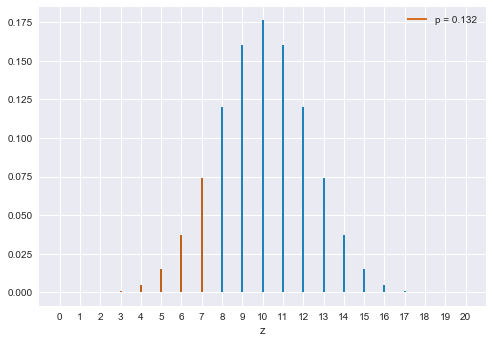

In [3]:
n = 20   # cantidad de veces que arrojamos la moneda en el experimento
p = 0.5  # si H0 entonces p=0.5 (igual proporción de caras y cecas)
caras_obs = sum(monedas_obs) 
dist_monedas = stats.binom(n, p);
x = np.arange(0, n + 1)
y = dist_monedas.pmf(x)
valor_p = sum(y[:caras_obs+1])
plt.vlines(x, 0, y, 'C0')
plt.vlines(x[:caras_obs+1], 0, y[:caras_obs+1], 'C2',
           label='p = {:.3f}'.format(valor_p))
plt.legend()
plt.xticks(x)
plt.xlabel('z');

#### Interpretando los resultados

Recapitulemos lo que acabamos de hacer es calcular la probabilidad de obtener 0, 1, ... 20 caras (barras azules), esto se llama _distribución de muestreo (sampling distribution)_. Y es la distribución de nuestro _estadístico_ $z$ para una muestra finita de $n=20$. 

Esta distribución es central en estadística frecuentista. De hecho a partir de ella hemos calculado la probabilidad de obtener 7 o menos caras (barras naranja), el _valor p_. 

¿Cómo se interpreta el _valor p_? 

Bueno, desde el punto de vista frecuentista las probabilidades viven en _asintópia_ un mundo donde las probabilidades son frecuencias que se obtienen en el límite de infinitas repeticiones de un mismo experimento. Entonces la interpretación sería:

    Si arrojaramos 20 veces al aire una moneda NO SESGADA y esto lo repetimos infinitas veces entonces el 13.2 % de las veces obtendremos 7 o menos caras. 

Es decir hemos encontrado la respuesta al pregunta ¿Cuán _esperable_ es este resultado para una moneda que _debería_ caer la mitad de las veces cara?

Otra pregunta _natural_ sería ¿Es realmente _diferente_ este resultado de $H_0$? Para dar respuesta a esta pregunta se suele usar el concepto (o "confupto" es decir concepto confuso) de significancia estadística, que consiste, como ya adelantamos, en comparar el _valor p_ con el valor predeterminado $\alpha$:

* Si p < 0.05, entonces la diferencia es estadísticamente significativa
* Si p < 0.001, entonces la diferencia es estadísticamente altamente-significativa

En este caso como p > 0.05 diríamos: "Se falla en rechazar la hipótesis nula con un p=0.132 y un nivel de significancia de 0.05".

Si esto suena a _rito umbanda_ es por que algo de eso hay! ¿De donde salen esos números? La verdad es que son arbritrarios y son casi consecuencia de accidentes históricos. Lamentablemente se ha vuelto muy común que estos límites se utilicen para definir si resultados son publicables o no. El límite dependerá de la revista/disciplina, siendo 0.05 común por ej en psicología y en varias ramas de la biología.

La intención de fijar un valor de $\alpha = 0.05$ es la de controlar el nivel de errores de tipo I. Es decir las falsas alarmas o más formalemente controlar la cantidad de veces que estamos dispuestos a rechazar una hipótesis nula verdadera (es decir una que NO deberíamos haber rechazado).

#### Problemas con las prueba de hipótesis nula

Esta aproximación tiene varios problemas

1. Impone una forma de pensar dicotómica, que suele ser inapropiada en la mayoría de los estudios científicos.
2. Los *valor p* omiten muchos factores, información previa, nivel de precisión/incerteza de la estimación.
3. Un efecto estadísticamente significativo no tiene por que ser un efecto relevante.
4. Los _valores p_ dependen de las intenciones del observador! Si el experimento A es tirar $N$ veces una moneda y contar el número de caras y el experimento B es tirar una moneda hasta que obtener $z$ caras. El _valor p_ no necesariamente es el mismo aún si en ambos experimentos observamos que $N=10, z=7$). La razón es que las _distribuciones de muestro_ son diferentes en ambos casos, aún cuando los datos sean idénticos.
5. En general los *valores p* son interpretados erroneamente. Un trabajo mostró que solo el 62% de los encuestados fue capaz de contestar de forma correcta sobre la definición de los *valores p*. Lo interesante es que en realidad ninguna de las respuestas provistas en este estudio correspondía a una definición correcta de los _valores p_! Los *valores p* NO son:
    * La probabilidad de que $H_0$ sea cierta
    * La probabilidad de que $ no H_0$ falsa
    * La probabilidad de cometer un error al rechazar $H_0$
    * La probabilidad de que los datos observados se hayan dado por *azar*
    * Una forma de indicar que NO hay efecto si p > 0.5 (o el nivel que sea)
    * Una medida de la *relevancia* de un efecto.
    

Gran parte de los problemas derivados de los *valores p*, provienen de usarlos como parte de la maquinaria de "prueba de hipótesis nula". La otra parte del problema de usar los _valores p_ proviene quizá de que estos no derivan de un sistema formal de cálculo de probabilidades si no que fueron introducidos de forma totalmente _ad hoc_. Como veremos más adelante la Estadística Bayesiana provee de algo llamado factores de Bayes que curiosamente es todo lo que usted siempre quiso que un _valor p_ fuera, pero que el _valor p_ NO puede ser.

Una forma de usar los _valores p_ sin meter la pata es no pedirle que ofrezcan la información que no pueden ofrecer. Un _valor p_ debería ser usado con el fin que originalmente se postuló: Una forma aproximada, cuando se cuenta con poca información sobre un problema, para intentar estimar (de forma objetiva) si vale la pena seguir mirando los datos o haciendo experimentos a fin de replicar o extender resultados. Entonces en general valores "bajos" de los _valores p_ indicarían que es posible que tengamos algo interesante. Por ejemplo algunos autores recomiendan de forma _muuuy_ general interpretar los _valores p_ de la siguiente manera 

* p < 0.01 Hey parece que tenemos algo! :-)
* p > 0.1 humm al parecer no hay mucho que decir :-(
* 0.01 < p < 0.1 La vida rara vez nos ofrece respuestas claras! :-|

#### Pruebas de una y dos colas

...Tener en cuenta que hemos calculado solo una cola de la distribución, obtener  las caras obtenidas o menos. Podríamos haber preguntado la probabildiad de obtener menos de 7 caras o menos de 7 cecas.... Lo primero se llama "prueba de una cola", el segundo "prueba de dos colas".

Los _valores p_ se pueden calcualr de forma directa, sin necesidad de hacer simulaciones, si conocemos la cdf de la distribución de muestreo. Usando SciPy esto es simple:

In [4]:
dist_monedas.cdf(7)

0.13158798217773435

 si p=0.5 entonces la distribución es simétrica por lo tanto si queremos calcular la probabilidad de valores "extremos" para ambas colas solo tenemos que multiplicar por 2

In [5]:
dist_monedas.cdf(7) * 2

0.26317596435546869

### Valores p por simulación

Supongamos que son un poco escépticos sobre el uso de la distribución binomial, para resolver estre problema. Una alternativa al cálculo analítico que acabamos de hacer es usar Python para simular que arrojamos nonedas al aire!

1. Vamos a asumir que la moneda tiene la misma chance de caer cara (1) o ceca (0)
2. Vamos a lanzar una moneda 20 veces (igual que en nuestros datos)
3. Vamos a repetir el punto 2, una gran catidad de veces (por ej 10000 más o menos)
4. Vamos a contar todas las veces que obtengamos 7 o menos caras.

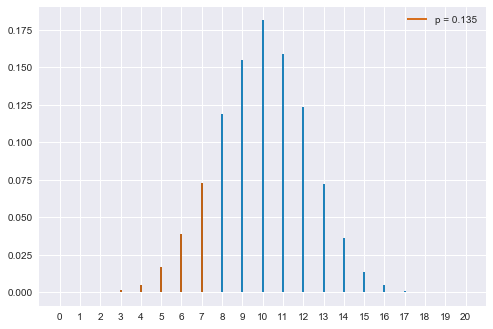

In [6]:
n = len(monedas_obs)
caras_sim_l = []
ite = 10000
for i in range(0, ite):
    monedas_sim = np.random.randint(0, 2, size=n)
    caras_sim = sum(monedas_sim)
    caras_sim_l.append(caras_sim)
x = np.arange(0, n + 1)
y = np.histogram(caras_sim_l, np.arange(0, n+1), normed=True)[0]
# como y está normalizado, esta linea es una probabilidad
valor_p = sum(y[:caras_obs+1])
plt.vlines(x, 0, y, 'C0')
plt.vlines(x[:caras_obs+1], 0, y[:caras_obs+1], 'C2',
           label='p = {:.3f}'.format(valor_p))
plt.legend()
plt.xticks(x);

## Maxima verosimilitud e intervalos de  confianza

Bien, al parecer los *valores p* y la idea de la prueba de hipótesis nulas no son del todo buenas ideas. Una solución a este problema (sin abandonar las ideas frecuentistas) es tratar de hacer una estimación puntual que resuma lo observado. Un ejemplo de estimación puntual es la media de una muestra.

Suele ser buena idea acompañar la estimación puntual con una medida de la incertidumbre asociada a la estimación puntual. La idea es contar con una estimación del rango de valores plausibles.

1. Una estimación puntual es el valor más plausible de un parámetro, por lo tanto tiene sentido indicar la incerteza alrededor de el.
2. La plausibilidad del intervalo de confianza se puede construir partir de la distribución de muestreo.

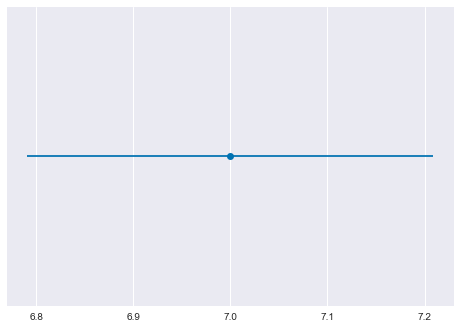

In [7]:
dist_monedas = stats.binom(n=20, p=7/20)
media = dist_monedas.mean()
std_error =  dist_monedas.std()/n
li = std_error * 1.96  # esta cantidad se resta a la media
ls = std_error * 1.96  # esta cantidad se suma a la media

plt.errorbar(x=media, y=0, xerr=[[li, ls]], fmt='o')
plt.yticks([]);

* Mostrar como calcular MLE en general
* Mostrar minimos cuadrados como caso particular
* Mostrar como usar bootstrtaping con la regresión lineal

## Ejercicios

1. graficar dist_monedas.cdf() en el rango de 0 a 20. Luego lo mismo pero para un n más grande  por ejmplo 1000